# Teaching A Quadcopter How To Fly

---

## Introduction

The [**quadcopter**](https://en.wikipedia.org/wiki/Quadcopter) (or **quadrotor helicopter**) is becoming an increasingly popular aircraft for both personal and professional use. Its maneuverability lends itself to many applications, from last-mile delivery to cinematography, from acrobatics to search-and-rescue.

Most quadcopters have 4 motors to provide thrust, although some other models with 6 or 8 motors are also sometimes referred to as quadcopters.

Multiple points of thrust with the center of gravity in the middle improves stability and enables a variety of flying behaviors. But it also comes at a price, the high complexity of controlling such an aircraft makes it almost impossible to manually control each individual motor's thrust. So, most commercial quadcopters try to simplify the flying controls by accepting a single thrust magnitude and yaw/pitch/roll controls, making it much more intuitive and fun.

<img src="assets/quadcopter.jpg">

The next step in this evolution is to enable quadcopters to autonomously achieve desired control behaviors such as takeoff and landing. These controls can be designed with a classic approach (say, by implementing PID controllers). Or we can use **reinforcement learning** to build agents that can learn these behaviors on their own. This is what we are going to do in this project!

Below, we can visualize two videos illustrating a quadcopter in action.

In [1]:
%%HTML
<video height="250" controls>
    <source src="assets/video_1.mp4" type="video/mp4">
</video>

In [2]:
%%HTML
<video height="250" controls>
    <source src="assets/video_2.mp4" type="video/mp4">
</video>

---

## Instructions and Imports

First, we can take a look at the files in the directory to better understand the structure of the project: 
- `task.py`: Our (basic) task (environment) is defined in this file.
- `proper_task.py`: Our (proper) task (environment) is defined in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Our agent is developed here.
    - `actor.py`: Our actor policy model is developed here.
    - `critic.py`: Our critic value model is developed here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.

Now, as a technical requisite, we are going to load the necessary Python libraries required for this project.

In [3]:
# Needed imports:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random, csv, sys, time
from task import Task
from proper_task import ProperTask
from mpl_toolkits.mplot3d import Axes3D
from agents.policy_search import PolicySearch_Agent
from agents.agent import DDPG

Using TensorFlow backend.


---

## Controlling the Quadcopter

Here, we provide a sample agent in the code cell below to show how to use the sim to control the quadcopter: This agent is even simpler than the sample agent that we will examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.

The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors, and these four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, obviously, the agent that we will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [4]:
# A simple agent to show how to use the sim to control the quadcopter:
class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Now, we can run the code cell below to have the agent select actions to control the quadcopter.  

*Nota Bene:* We can freely change the provided values of `runtime`, `init_pose`, `init_velocities` and `init_angle_velocities` to change the starting conditions of the quadcopter.

*Nota Bene:* The `labels` list annotates statistics that are saved while running the simulation: All of this information is saved in a text file `basic_agent_data.txt`, located in the folder `results`, and stored in the dictionary `results`.

In [5]:
# Modify the values below to give the quadcopter a different starting position:
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'results/basic_agent_data.txt'     # file name for saved results

# Setup:
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time',
          'x', 'y', 'z',
          'phi', 'theta', 'psi',
          'x_velocity', 'y_velocity', 'z_velocity',
          'phi_velocity', 'theta_velocity', 'psi_velocity',
          'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation and save the results:
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

To visualize how the position of the quadcopter evolved during the simulation, we can run the code cell below:

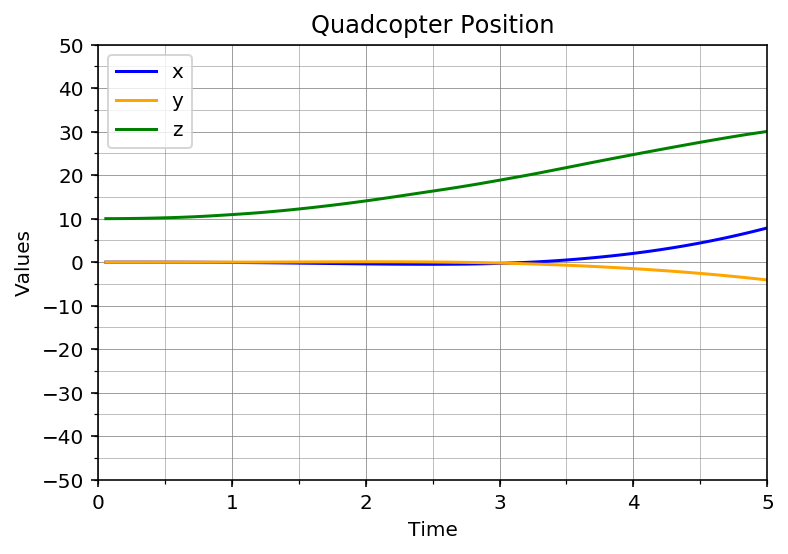

In [6]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Quadcopter Position')
ax.plot(results['time'], results['x'], color='blue', linestyle='-', label='x')
ax.plot(results['time'], results['y'], color='orange', linestyle='-', label='y')
ax.plot(results['time'], results['z'], color='green', linestyle='-', label='z')
ax.legend()
ax.set_xlim(0., 5.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Time')
ax.set_ylim(-50., 50.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Values')

# Save the graph:
fig.savefig('results/basic_agent_position.png')

The next code cell allows us to visualize the velocity of the quadcopter within each each of the 3 space's directions during the simulation:

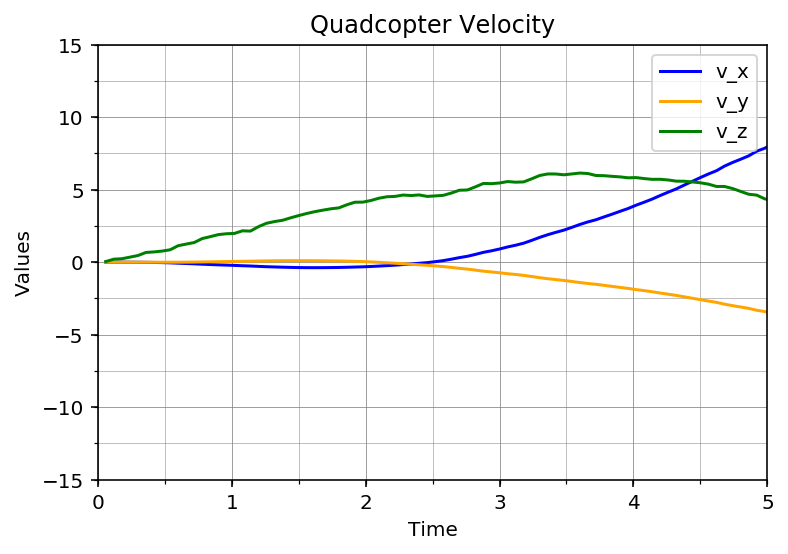

In [7]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Quadcopter Velocity')
ax.plot(results['time'], results['x_velocity'], color='blue', linestyle='-', label='v_x')
ax.plot(results['time'], results['y_velocity'], color='orange', linestyle='-', label='v_y')
ax.plot(results['time'], results['z_velocity'], color='green', linestyle='-', label='v_z')
ax.legend()
ax.set_xlim(0., 5.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Time')
ax.set_ylim(-15., 15.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(13))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Values')

# Save the graph:
fig.savefig('results/basic_agent_velocity.png')

Next, we can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes) during the simulation:

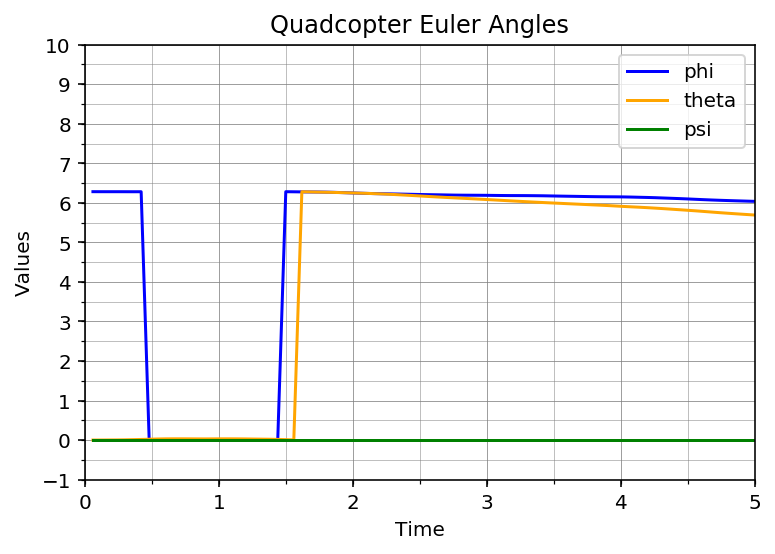

In [8]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Quadcopter Euler Angles')
ax.plot(results['time'], results['phi'], color='blue', linestyle='-', label='phi')
ax.plot(results['time'], results['theta'], color='orange', linestyle='-', label='theta')
ax.plot(results['time'], results['psi'], color='green', linestyle='-', label='psi')
ax.legend()
ax.set_xlim(0., 5.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Time')
ax.set_ylim(-1., 10.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(12))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(23))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Values')

# Save the graph:
fig.savefig('results/basic_agent_euler_angles.png')

Then, we can plot the velocities (in radians per second) corresponding to each of the Euler angles during the simulation:

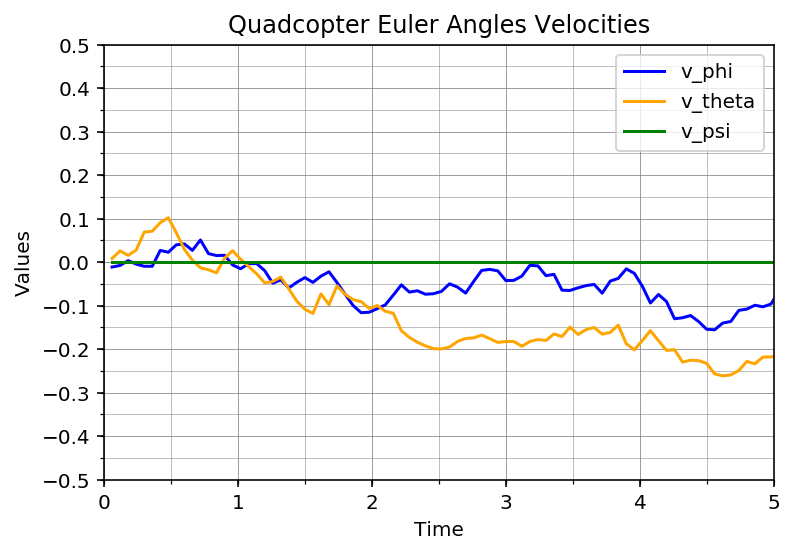

In [9]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Quadcopter Euler Angles Velocities')
ax.plot(results['time'], results['phi_velocity'], color='blue', linestyle='-', label='v_phi')
ax.plot(results['time'], results['theta_velocity'], color='orange', linestyle='-', label='v_theta')
ax.plot(results['time'], results['psi_velocity'], color='green', linestyle='-', label='v_psi')
ax.legend()
ax.set_xlim(0., 5.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Time')
ax.set_ylim(-0.5, 0.5)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Values')

# Save the graph:
fig.savefig('results/basic_agent_euler_angles_velocities.png')

Finally, we can use the code cell below to print the agent's choice of actions during the simulation:

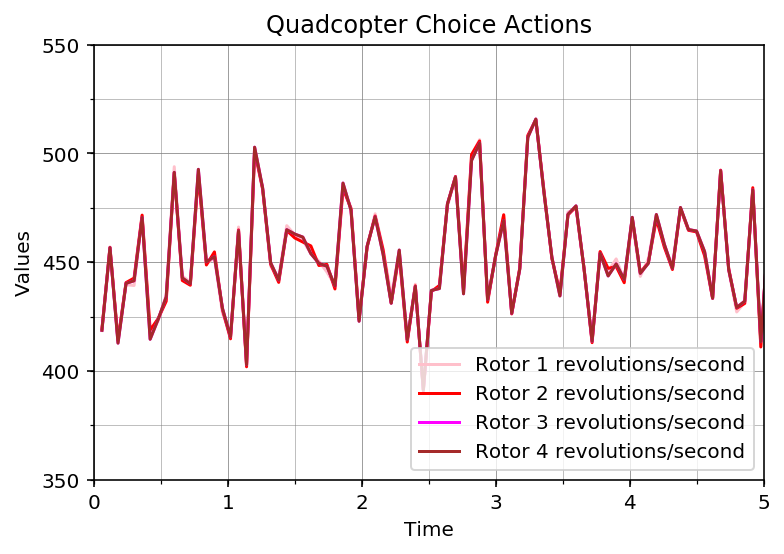

In [10]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Quadcopter Choice Actions')
ax.plot(results['time'], results['rotor_speed1'], color='pink', linestyle='-', label='Rotor 1 revolutions/second')
ax.plot(results['time'], results['rotor_speed2'], color='red', linestyle='-', label='Rotor 2 revolutions/second')
ax.plot(results['time'], results['rotor_speed3'], color='magenta', linestyle='-', label='Rotor 3 revolutions/second')
ax.plot(results['time'], results['rotor_speed3'], color='brown', linestyle='-', label='Rotor 4 revolutions/second')
ax.legend()
ax.set_xlim(0., 5.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Time')
ax.set_ylim(350., 550.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(9))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Values')

# Save the graph:
fig.savefig('results/basic_agent_euler_choice_actions.png')

When specifying a task, we will derive the environment state from the simulator.

Running the code cell below, we will print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x, y, z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x, y, z$) dimensions), and,
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [11]:
# Position, velocity and angular velocity of the quadcopter at the end of the episode:
print("*** Summary at the end of the episode:")
print("- Position:", task.sim.pose)
print("- Velocity:", task.sim.v)
print("- Angular Velocity:", task.sim.angular_v)

*** Summary at the end of the episode:
- Position: [  8.19459031  -4.23752699  30.23053869   6.03508902   5.68391851   0.        ]
- Velocity: [ 8.16071805 -3.53205332  4.25148151]
- Angular Velocity: [-0.06704914 -0.2141249   0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.

*Nota Bene:* When amending the task for our purposes, we can freely expand the size of the state vector by including the velocity information: For example, we can use any combination of the pose, velocity, and angular velocity.

---

## The Task

A sample task has been provided in `task.py`. 

The `__init__()` method is used to initialize several variables that are needed to specify the task:
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).
- Inspired by the methodology in the original DDPG paper, we make use of action repeats. For each timestep of the agent, we step the simulation `action_repeats` timesteps (if you are not familiar with action repeats, please read the "Results" section in [the DDPG paper](https://arxiv.org/abs/1509.02971)).
- We set the number of elements in the state vector. For the sample task, we only work with the 6-dimensional pose information. To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). We can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this file is for the agent to reach a target position (we specify that target position as a variable).

The `reset()` method resets the simulator. The agent should call this method every time the episode ends (an example of this can be observed in the code cell below).

The `step()` method is perhaps the most important. It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent. Then, the reward is computed from `get_reward()`. The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, we will learn how to test the performance of an agent on this task.

---

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

We can run the code cell below to see how the agent performs on the sample task.

In [12]:
# Initialization of the run:
print("*** Summary of the run:")
start_time = time.time()

# Parameters initialization:
num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

# Perform a run:
for i_episode in range(1, num_episodes + 1):
    # Start a new episode:
    state = agent.reset_episode()
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\r- Episode = {}, score = {:.3f} (best = {:.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")
            break
    sys.stdout.flush()
    
# Time performance:
end_time = time.time()
total_time = int(end_time - start_time)
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = (total_time % 3600) % 60

print("\n- Time Performance = {:02d}h {:02d}m {:02d}s".format(hours, minutes, seconds))

*** Summary of the run:
- Episode = 1000, score = -1.796 (best = -0.097), noise_scale = 3.2
- Time Performance = 00h 00m 18s


As it was expected, this agent perform very poorly on this task...

---

## Define our proper Task and Design & Train our Agent!

### Introduction

Here, our objective will be to teach our quadcopter to reach a target position: (0, 0, 100).

*Nota Bene:* We could have perfectly chosen, too, to teach our quadcopter to takeoff, hover in place or land softly.

For this task, our agent is defined in `agents/agent.py`.

*Nota Bene:* For these activities, it is **highly unlikely** that the first agent and task that we specify will learn well, we will likely have to tweak various hyperparameters and the reward function for our task until we arrive at reasonably good behavior.

As we develop our agent, it's important to keep an eye on how it's performing: We need to build in a mechanism to log and save the total rewards obtained in each episode to file.

If the episode rewards are gradually increasing, this is an indication that our agent is learning!

In [13]:
# Initialization of the run:
print("*** Summary of the run:")
start_time = time.time()

# Parameters initialization:
num_episodes = 500
target_pos = np.array([0., 0., 100.])
task = ProperTask(target_pos=target_pos)
agent = DDPG(task) 
worst_score = 1000000.
best_score = -1000000.
reward_log = "results/agent_reward.txt"
reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}

# Perform a run:
for i_episode in range(1, num_episodes + 1):
    # Start a new episode:
    state = agent.reset_episode()
    score = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        score += reward
        best_score = max(best_score, score)
        worst_score = min(worst_score, score)
        if done:
            print("\r- Episode = {}, score = {:.3f} (best = {:.3f}, worst = {:.3f})".format(
                i_episode, score, best_score, worst_score), end="")
            break
    reward_results['episode'].append(i_episode)
    reward_results['reward'].append(score)
    sys.stdout.flush()

# Time performance:
end_time = time.time()
total_time = int(end_time - start_time)
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = (total_time % 3600) % 60

print("\n- Time Performance = {:02d}h {:02d}m {:02d}s".format(hours, minutes, seconds))

*** Summary of the run:
- Episode = 500, score = 576.504 (best = 579.642, worst = 6.439)
- Time Performance = 00h 25m 43s


### Plot the Rewards

To observe the results we have obtained above, we are now going to plot the evolution of the rewards.

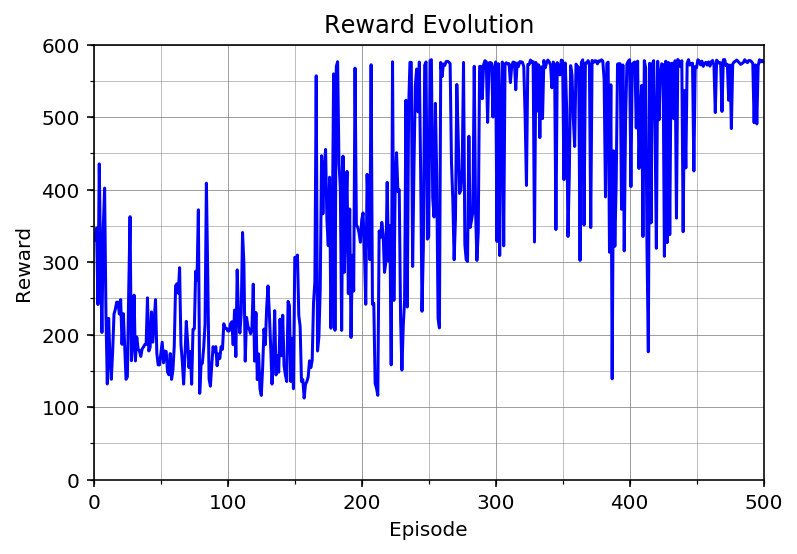

In [14]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Reward Evolution')
ax.plot(reward_results['episode'], reward_results['reward'], color='blue', linestyle='-')
ax.legend()
ax.set_xlim(0., 500.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Episode')
ax.set_ylim(0., 600.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(13))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Reward')

# Save the graph:
fig.savefig('results/proper_agent_reward.png')

### Check the Result of the Learning

We can now check the result of the previous learning and evaluate how well our agent evolves during one episode in the environment, comparing the obtained reward in reference to the above reward graph.

In [15]:
# Modify the values below to give the quadcopter a different starting position:
runtime = 5000.                                  # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'results/proper_agent_data.txt'     # file name for saved results

# Setup:
task = ProperTask(init_pose, init_velocities, init_angle_velocities, runtime)
done = False
labels = ['time',
          'x', 'y', 'z',
          'phi', 'theta', 'psi',
          'x_velocity', 'y_velocity', 'z_velocity',
          'phi_velocity', 'theta_velocity', 'psi_velocity',
          'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation and save the results:
state = agent.reset_episode()
total_reward = 0
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act(state)
        next_state, reward, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        total_reward += reward
        state = next_state
        if done:
            print("=> Total episode reward: {}".format(total_reward))
            total_reward = 0
            break

=> Total episode reward: 514.9468972646164


The reward obtained is aligned with the ones we reached in the last episodes of our previous learning.

Let's see how perform our agent during the episode!

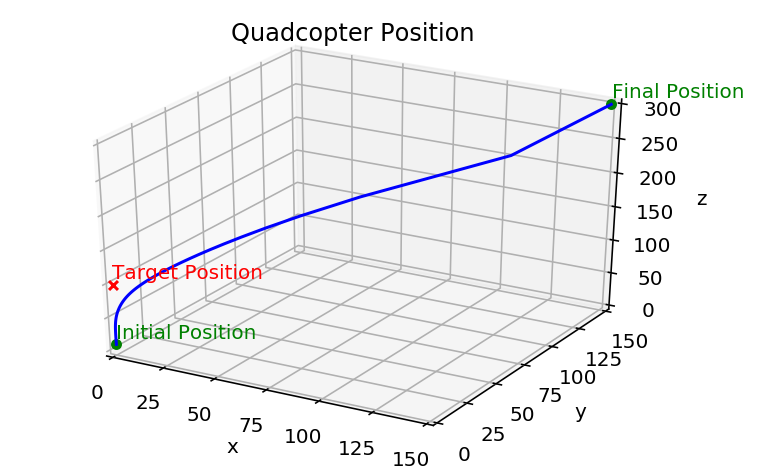

In [19]:
# Define the graph:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Configuration of the graph:
ax.set_title('Quadcopter Position')
ax.plot(results['x'], results['y'], results['z'], color='blue', linestyle='-')
ax.scatter(0, 0, 10, color='green', marker='o')
ax.text(0, 0, 20, 'Initial Position', color='green')
ax.scatter(results['x'][-1], results['y'][-1], results['z'][-1], color='green', marker='o')
ax.text(results['x'][-1], results['y'][-1], results['z'][-1] + 10, 'Final Position', color='green')
ax.scatter(0, 0, 100, color='red', marker='x')
ax.text(0, 0, 110, 'Target Position', color='red')
ax.legend()
ax.set_xlim(0., 150.)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.set_xlabel('x')
ax.set_ylim(0., 150.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.set_ylabel('y')
ax.set_zlim(0., 300.)
ax.zaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
ax.set_zlabel('z')

# Save the graph:
fig.savefig('results/proper_agent_position.png')

### Conclusion

In this project, our objective has been to teach our quadcopter to reach a target position: (0, 0, 100) from its initial position: (0, 0, 10), task which difficulty has seemed to us reasonable.

To achieve this objective, we finally arrived to the following reward function (see the file `proper_task.py`):

`reward = np.tanh(1 - 0.003*(abs(self.sim.pose[:3] - self.target_pos))).sum()`

Thus, we tried to keep a quite simple reward function, increasing the rewards when our agent gets near the target position, and normalizing between -1 and 1 the rewards thanks to the hyperbolic tangent function.

Furthermore, we used for our agent the DDPG algorithm, thanks to the implementation of the actor policy model, the critic value model, the Ornstein-Uhlenbeck noise process and the replay memory buffer.

During our effort to optimize this approach, we tried to follow the instructions and specifications given in the DDPG paper, changing the various hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc, etc) to test their effects.

Finally, we fixed our choices as described below:
- For the actor policy model, we used two fully connected layers with 400 and 300 units respectively, L2 regularizers, batch normalization and ReLU activation functions, and for the output layer, we implemented a tanh activation function, following the suggestion developed in the DDPG paper (according to this document, we also set the learning rate of Adam optimizer to 0.0001);
- For the critic value model, we used the same architecture for the state and action paths: two fully connected layers with 400 and 300 units, L2 regularizers, batch normalization and ReLU activation functions (we implemented a learning rate of 0.001 for the Adam optimizer).

Additionally, if we put the focus on the graph representing the evolution of the reward over the episodes, three major elements can be noted, in my opinion:
- The reward curve is very noised, unstable, element which traduces the difficulty to reach the realization of the task we have defined;
- From episode 150, approximatively, our agent begin to learn, rewards by episode increase from the value 200, approximatively, to the value 570, approximatively;
- At the end, from episode 250, approximatively, our agent doesn't seem to learn more things, being unable to outperform the rewards by episode it has reached.

To conclude, Deep Reinforcement Learning is a complex playground, and state-of-the-art methods like the DDPG algorithm, we have used here, although performant, are not easy to put at work.

Working on the reward function and the networks architecture, to make them perform well on the task we have defined, is very time consuming and tricky!

Above, as it can be seen in the previous graph, we have achieved to make our agent to fly (and not to crash...), nevertheless, we haven't been able to make it reach the target position we have defined...

To go beyond what has been obtained here, complementary work can be made on the reward function, to reach the target position (e.g. penalize the agent if it flies too high or too low, penalize movements along the x and y-axes, etc, etc).